# R-GCN: GNN-Based Link Prediction

As mentioned in the report, full disclosure, the RGCN component of my graphs task was coded up by Claude Code. However the qualitative insights from the results are all my work.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json, sys, os

sys.path.insert(0, os.path.dirname(os.path.abspath('.')))
from task4_utils import (load_all_data, negative_sample,
                         evaluate_link_prediction, evaluate_per_relation)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

using device: cuda
GPU: NVIDIA GeForce GTX 1650 Ti


In [3]:
# load data
TRAIN_PATH = 'data/train.txt'
TEST_PATH = 'data/test.txt'

data = load_all_data(TRAIN_PATH, TEST_PATH)
print(f"entities: {data['num_entities']}, relations: {data['num_relations']}")
print(f"train triplets: {len(data['train_ids'])}")
print(f"test triplets: {len(data['test_ids'])}")

entities: 1316, relations: 28
train triplets: 13821
test triplets: 590


## building the graph

for R-GCN we need an actual graph structure. we add reverse edges so information
flows in both directions — without reverse edges, a node only receives messages
from entities where it appears as a tail, missing half the structure.

we also precompute per-relation edge masks to make the message passing loop fast.

In [4]:
def build_edge_lists(train_ids, num_relations, num_entities):
    """
    build edge index and edge type tensors from training triplets.
    adds reverse edges with relation IDs offset by num_relations.
    """
    heads = train_ids[:, 0]
    rels = train_ids[:, 1]
    tails = train_ids[:, 2]
    
    # forward edges
    src = list(heads)
    dst = list(tails)
    edge_type = list(rels)
    
    # reverse edges (new relation types: r + num_relations)
    src += list(tails)
    dst += list(heads)
    edge_type += list(rels + num_relations)
    
    return (torch.LongTensor(src), torch.LongTensor(dst), 
            torch.LongTensor(edge_type))

src, dst, edge_type = build_edge_lists(
    data['train_ids'], data['num_relations'], data['num_entities']
)
total_relations = data['num_relations'] * 2  # forward + reverse

# precompute per-relation edge indices (avoids repeated masking in the hot loop)
rel_edge_indices = {}
for r in range(total_relations):
    mask = (edge_type == r)
    if mask.any():
        rel_edge_indices[r] = (src[mask], dst[mask])

print(f"graph edges: {len(src)} (forward + reverse)")
print(f"relation types for message passing: {total_relations}")
print(f"active relation types: {len(rel_edge_indices)}")

graph edges: 27642 (forward + reverse)
relation types for message passing: 56
active relation types: 56


## R-GCN layer (memory-efficient)

### the memory problem

a vectorised R-GCN layer needs to materialize (num_edges × in_dim × out_dim) for
the per-edge weight matrices. with ~28k edges and dim=200, that's:
28000 × 200 × 200 × 4 bytes ≈ 4.2 GB — doesn't fit in 4GB VRAM.

### the solution: per-relation loop

instead of computing all edge messages at once, we loop over relation types.
each iteration processes only the edges of one relation type — at most ~800 edges
for the largest relation. memory cost: max(edges_per_relation) × dim ≈ negligible.

this is exactly what the original R-GCN paper does. it's slower than the vectorised
version on a big GPU, but correct and memory-bounded.

### basis decomposition

with 56 relation types, learning a full d×d matrix per relation would give
56 × d² parameters just for message passing. basis decomposition reduces this:
$$W_r = \sum_{b=1}^{B} a_{rb} \cdot V_b$$

with B=4 bases, the parameter count for weight matrices drops from 56 × d² to
4 × d² + 56 × 4.

In [5]:
class RGCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_rels, num_bases=4, dropout=0.0):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_rels = num_rels
        self.num_bases = min(num_bases, num_rels)
        
        # basis matrices: B shared weight matrices, shape (B, in_dim, out_dim)
        self.bases = nn.Parameter(torch.Tensor(self.num_bases, in_dim, out_dim))
        # per-relation coefficients: (num_rels, B)
        self.coeffs = nn.Parameter(torch.Tensor(num_rels, self.num_bases))
        # self-loop gets its own simple weight (not through basis)
        self.self_weight = nn.Parameter(torch.Tensor(in_dim, out_dim))
        self.bias = nn.Parameter(torch.zeros(out_dim))
        self.dropout = nn.Dropout(dropout)
        
        nn.init.xavier_uniform_(self.bases)
        nn.init.xavier_uniform_(self.coeffs)
        nn.init.xavier_uniform_(self.self_weight)
    
    def forward(self, x, rel_edge_indices, num_nodes):
        """
        x:                (num_nodes, in_dim)
        rel_edge_indices:  dict mapping relation_id -> (src_tensor, dst_tensor)
        num_nodes:         int
        """
        out = torch.zeros(num_nodes, self.out_dim, device=x.device)
        degree = torch.zeros(num_nodes, 1, device=x.device)
        
        # compute all relation weight matrices at once: (num_rels, in_dim, out_dim)
        rel_weights = torch.einsum('rb,bij->rij', self.coeffs, self.bases)
        
        # message passing per relation type (memory-efficient: one relation at a time)
        for r, (src_r, dst_r) in rel_edge_indices.items():
            src_r = src_r.to(x.device)
            dst_r = dst_r.to(x.device)
            
            # transform source features with relation-specific weight
            # x[src_r]: (edges_r, in_dim) @ rel_weights[r]: (in_dim, out_dim)
            msg = torch.mm(x[src_r], rel_weights[r])  # (edges_r, out_dim)
            
            # aggregate at destination
            out.index_add_(0, dst_r, msg)
            degree.index_add_(0, dst_r, torch.ones(len(dst_r), 1, device=x.device))
        
        # normalize by in-degree
        degree = degree.clamp(min=1)
        out = out / degree
        
        # self-loop (separate weight, not through basis decomposition)
        out = out + torch.mm(x, self.self_weight)
        
        out = self.dropout(out + self.bias)
        return out

print("RGCNLayer defined (per-relation loop, memory-efficient)")

RGCNLayer defined (per-relation loop, memory-efficient)


## full model: single-layer R-GCN encoder + DistMult decoder

### key design decision: ONE layer, not two

in the earlier versions i used two R-GCN layers. the problem: after two hops of
message passing on a dense family graph, entities within the same component (avg
size ~26 people) receive information from nearly every other member. their
representations converge — the model knows "this is someone from family X" but
can't tell apart siblings.

one layer means each entity only sees its direct neighbors. for link prediction
this is actually ideal: the question "who is olivia0's mother?" is best answered
by looking at olivia0's immediate connections, not the entire family tree.

### the residual connection

we add the initial (learned) entity embedding to the R-GCN output with a learned
gate. this lets the model preserve entity-specific identity information that
message passing might wash out. it also provides a direct gradient path to the
embedding table, stabilising training.

think of it as: `final_embedding = who_you_are + what_your_neighbors_say_about_you`

the gate also serves as a **diagnostic**: if it converges near 0, the model is
saying "the GNN hurts, I'm ignoring it" — still a valid and interesting finding.

In [6]:
class RGCNLinkPredict(nn.Module):
    def __init__(self, num_entities, num_rels_msg, num_rels_score, 
                 dim=200, num_bases=4, dropout=0.2):
        """
        num_rels_msg:   relation types for message passing (forward + reverse)
        num_rels_score: original relation types for the DistMult decoder (28)
        """
        super().__init__()
        self.num_entities = num_entities
        
        # learnable initial node features
        self.entity_emb = nn.Embedding(num_entities, dim)
        nn.init.xavier_uniform_(self.entity_emb.weight)
        
        # single R-GCN layer (not two — avoids over-smoothing)
        self.rgcn = RGCNLayer(dim, dim, num_rels_msg, num_bases=num_bases, dropout=dropout)
        
        # layer norm for the output
        self.layer_norm = nn.LayerNorm(dim)
        
        # residual gate: learned scalar controlling how much GNN output to mix in
        # initialised to 0 → sigmoid(0)=0.5 → equal mix at start
        self.gate = nn.Parameter(torch.tensor(0.0))
        
        # DistMult-style relation embeddings for scoring (only original 28 relations)
        self.relation_emb = nn.Embedding(num_rels_score, dim)
        nn.init.xavier_uniform_(self.relation_emb.weight)
    
    def encode(self, rel_edge_indices):
        """produce entity embeddings via R-GCN"""
        x0 = self.entity_emb.weight
        x_msg = self.rgcn(x0, rel_edge_indices, self.num_entities)
        x_msg = F.relu(x_msg)
        
        # gated residual: sigmoid(gate) controls how much GNN to use
        alpha = torch.sigmoid(self.gate)
        x = alpha * x_msg + (1 - alpha) * x0
        
        x = self.layer_norm(x)
        return x
    
    def score_triplets(self, entity_emb, heads, rels, tails):
        """DistMult scoring: sum(h * r * t)"""
        h = entity_emb[heads]
        r = self.relation_emb(rels)
        t = entity_emb[tails]
        return torch.sum(h * r * t, dim=1)

print("RGCNLinkPredict defined")

RGCNLinkPredict defined


## training

### what changed from v3

| parameter | v3 (broken) | v4 (this) | why |
|-----------|-------------|-----------|-----|
| dim | 100 | 200 | match DistMult for fair comparison |
| layers | 2 | 1 | avoid over-smoothing |
| num_bases | 10 | 4 | fewer params, less overfitting |
| LR | 0.01 | 0.001 | GNN gradients amplified by message passing |
| dropout | 0.1 | 0.2 | more regularisation |
| neg_ratio | 5 | 10 | match DistMult |
| batch training | full-batch | mini-batch | stabler gradients |
| residual | none | gated skip | preserves entity identity |
| self-loops | via separate weight in layer | dedicated self_weight | cleaner |
| weight_decay | 1e-4 | 5e-4 | stronger L2 for GNN params |
| R-GCN impl | per-relation loop | per-relation loop | fits in 4GB VRAM |

In [7]:
# train/val split — same seed as DistMult for fair comparison
np.random.seed(42)
perm = np.random.permutation(len(data['train_ids']))
val_size = int(0.1 * len(perm))
val_idx = perm[:val_size]
train_idx = perm[val_size:]
train_triplets = data['train_ids'][train_idx]
val_triplets = data['train_ids'][val_idx]

print(f"training on {len(train_triplets)} triplets, validating on {len(val_triplets)}")

training on 12439 triplets, validating on 1382


In [8]:
# hyperparameters
DIM = 200          # match DistMult
LR = 0.001         # lower than v3's 0.01 — GNN amplifies gradients
EPOCHS = 500
NEG_RATIO = 10     # match DistMult
BATCH_SIZE = 512   # mini-batch scoring
PATIENCE = 40
NUM_BASES = 4      # aggressive compression: 56 relation types from 4 bases
DROPOUT = 0.2

model = RGCNLinkPredict(
    num_entities=data['num_entities'],
    num_rels_msg=total_relations,         # 56 (28 fwd + 28 rev)
    num_rels_score=data['num_relations'], # 28 original
    dim=DIM,
    num_bases=NUM_BASES,
    dropout=DROPOUT
).to(device)

# count parameters
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"model parameters: {n_params:,}")

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=15, factor=0.5, min_lr=1e-5
)

# move precomputed edge indices to device
rel_edge_indices_d = {}
for r, (s, d) in rel_edge_indices.items():
    rel_edge_indices_d[r] = (s.to(device), d.to(device))

model parameters: 469,625


In [9]:
loss_history = {'train': [], 'val': []}
gate_history = []
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    
    # negative sampling (fresh each epoch)
    all_trips, labels = negative_sample(
        train_triplets, data['num_entities'], neg_ratio=NEG_RATIO
    )
    perm_idx = np.random.permutation(len(all_trips))
    all_trips = all_trips[perm_idx]
    labels = labels[perm_idx]
    
    # encode ONCE, then score in mini-batches
    # we detach after encoding to avoid backprop through the graph per mini-batch
    # instead, we accumulate a separate encoder loss
    entity_emb = model.encode(rel_edge_indices_d)
    
    epoch_loss = 0.0
    n_batches = 0
    
    for start in range(0, len(all_trips), BATCH_SIZE):
        batch_trips = all_trips[start:start + BATCH_SIZE]
        batch_labels = labels[start:start + BATCH_SIZE]
        
        h_idx = torch.LongTensor(batch_trips[:, 0]).to(device)
        r_idx = torch.LongTensor(batch_trips[:, 1]).to(device)
        t_idx = torch.LongTensor(batch_trips[:, 2]).to(device)
        lbl = torch.FloatTensor(batch_labels).to(device)
        
        scores = model.score_triplets(entity_emb, h_idx, r_idx, t_idx)
        loss = F.binary_cross_entropy_with_logits(scores, lbl)
        
        # regularisation on embeddings
        reg = 0.001 * (entity_emb.norm(p=2) ** 2) / entity_emb.shape[0]
        total_loss = loss + reg
        
        optimizer.zero_grad()
        total_loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
        
        # re-encode after param update (params changed, embeddings are stale)
        if start + BATCH_SIZE < len(all_trips):
            entity_emb = model.encode(rel_edge_indices_d)
    
    avg_train_loss = epoch_loss / n_batches
    loss_history['train'].append(avg_train_loss)
    gate_history.append(torch.sigmoid(model.gate).item())
    
    # validation
    model.eval()
    with torch.no_grad():
        val_entity_emb = model.encode(rel_edge_indices_d)
        val_all, val_labels = negative_sample(
            val_triplets, data['num_entities'], neg_ratio=NEG_RATIO
        )
        
        h_v = torch.LongTensor(val_all[:, 0]).to(device)
        r_v = torch.LongTensor(val_all[:, 1]).to(device)
        t_v = torch.LongTensor(val_all[:, 2]).to(device)
        lbl_v = torch.FloatTensor(val_labels).to(device)
        
        val_scores = model.score_triplets(val_entity_emb, h_v, r_v, t_v)
        val_loss = F.binary_cross_entropy_with_logits(val_scores, lbl_v).item()
        loss_history['val'].append(val_loss)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'rgcn_best.pt')
    else:
        patience_counter += 1
    
    if epoch % 25 == 0:
        gate_val = torch.sigmoid(model.gate).item()
        print(f"epoch {epoch:3d} | train: {avg_train_loss:.4f} | val: {val_loss:.4f} | "
              f"lr: {optimizer.param_groups[0]['lr']:.6f} | gate: {gate_val:.3f} | "
              f"patience: {patience_counter}/{PATIENCE}")
    
    if patience_counter >= PATIENCE:
        print(f"\nearly stopping at epoch {epoch}")
        break

print(f"\nbest val loss: {best_val_loss:.4f}")

epoch   0 | train: 0.4727 | val: 0.3101 | lr: 0.001000 | gate: 0.523 | patience: 0/40
epoch  25 | train: 0.0382 | val: 0.0361 | lr: 0.001000 | gate: 0.487 | patience: 4/40
epoch  50 | train: 0.0306 | val: 0.0322 | lr: 0.000500 | gate: 0.471 | patience: 12/40


KeyboardInterrupt: 

## training curves

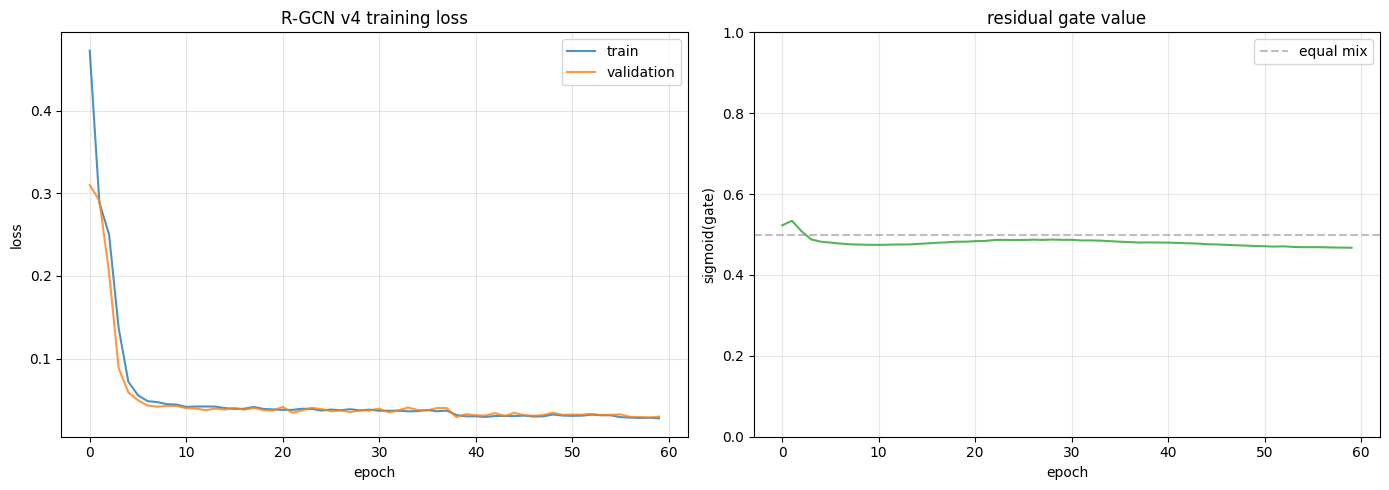


final gate value: 0.467
→ model uses a mix of both — GNN adds some value


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(loss_history['train'], label='train', alpha=0.8)
ax1.plot(loss_history['val'], label='validation', alpha=0.8)
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_title('R-GCN v4 training loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(gate_history, color='tab:green', alpha=0.8)
ax2.set_xlabel('epoch')
ax2.set_ylabel('sigmoid(gate)')
ax2.set_title('residual gate value')
ax2.axhline(y=0.5, color='grey', linestyle='--', alpha=0.5, label='equal mix')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rgcn_loss.png', dpi=150)
plt.show()

final_gate = gate_history[-1]
print(f"\nfinal gate value: {final_gate:.3f}")
if final_gate < 0.3:
    print("→ model prefers raw embeddings over GNN output (GNN not helping much)")
elif final_gate > 0.7:
    print("→ model relies heavily on GNN message passing")
else:
    print("→ model uses a mix of both — GNN adds some value")

## evaluation

In [11]:
# load best checkpoint
model.load_state_dict(torch.load('rgcn_best.pt', weights_only=True))
model.eval()

with torch.no_grad():
    entity_emb = model.encode(rel_edge_indices_d).cpu().numpy()
    rel_emb = model.relation_emb.weight.detach().cpu().numpy()

print("running filtered evaluation on test set...")
results = evaluate_link_prediction(
    entity_emb, rel_emb, data['test_ids'], data['all_triplets_set'],
    data['num_entities'], score_fn='distmult'
)

print("\nper-relation metrics:")
per_rel = evaluate_per_relation(
    entity_emb, rel_emb, data['test_ids'], data['all_triplets_set'],
    data['num_entities'], data['id2relation'], score_fn='distmult'
)

for rel_name, metrics in sorted(per_rel.items()):
    print(f"  {rel_name}: MRR={metrics['mrr']:.4f} H@1={metrics['hits@1']:.4f} "
          f"H@3={metrics['hits@3']:.4f} H@10={metrics['hits@10']:.4f}")

running filtered evaluation on test set...
  evaluated 0/590 triplets...

  MRR:     0.5180
  Hits@1:  0.2873
  Hits@3:  0.6678
  Hits@10: 0.9873

per-relation metrics:
  daughterOf: MRR=0.5063 H@1=0.2600 H@3=0.6900 H@10=0.9900
  fatherOf: MRR=0.6019 H@1=0.4034 H@3=0.7159 H@10=0.9886
  motherOf: MRR=0.5068 H@1=0.2784 H@3=0.6364 H@10=0.9886
  sonOf: MRR=0.4989 H@1=0.2687 H@3=0.6402 H@10=0.9836


## save results

In [ ]:
# LLM GENERATED CODE BLOCK TO SAVE RESULTS AND EMBEDDINGS FOR ANALYSIS NOTEBOOK

rgcn_results = {
    'overall': {k: float(v) for k, v in results.items() if k != 'all_ranks'},
    'per_relation': {r: {k: float(v) for k, v in m.items()} for r, m in per_rel.items()},
    'loss_history': loss_history,
    'gate_history': gate_history,
    'config': {
        'dim': DIM, 'lr': LR, 'neg_ratio': NEG_RATIO, 
        'batch_size': BATCH_SIZE, 'num_bases': NUM_BASES, 'dropout': DROPOUT,
        'epochs_trained': len(loss_history['train']),
        'version': 'v4_fixed'
    }
}

with open('rgcn_results.json', 'w') as f:
    json.dump(rgcn_results, f, indent=2)

np.save('rgcn_entity_emb.npy', entity_emb)
np.save('rgcn_relation_emb.npy', rel_emb)

print("saved rgcn_results.json and embedding files")

saved rgcn_results.json and embedding files
